In [2]:
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

/tmp/ipykernel_481180/2589586304.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamwater_data["Date"] = pd.to_datetime(streamwater_data["Date"], format="%m/%d/%Y", errors="coerce")
/tmp/ipykernel_481180/2589586304.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmember_data["Date"] = pd.to_datetime(endmember_data["Date"], format="%m/%d/%Y", errors="coerce")


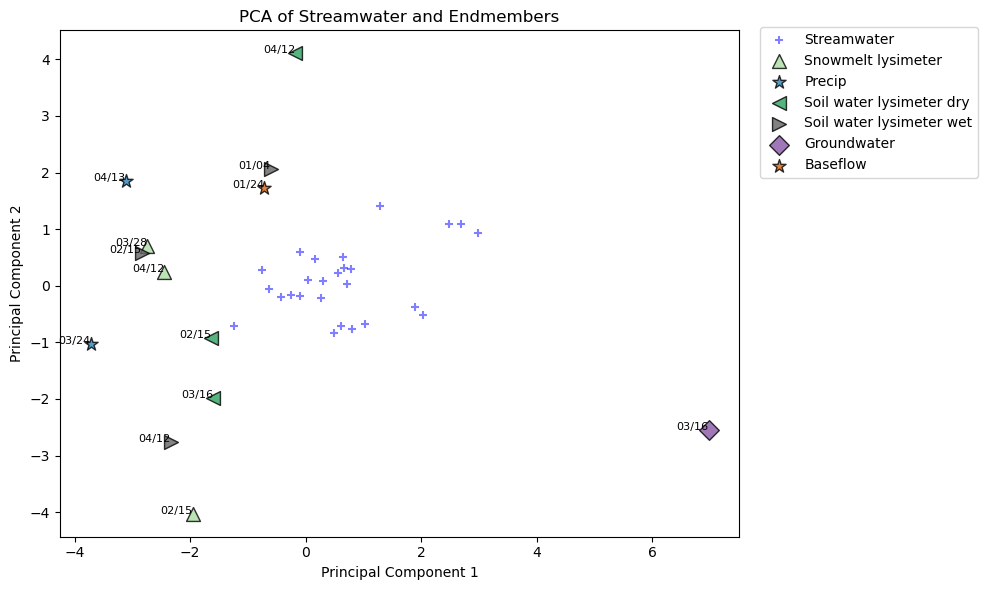

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")

# Filter streamwater and endmember data
streamwater_data = data.loc[
    (data['Site'] == "Hungerford") &
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

endmember_data = data.loc[
    (data['Site'] == "Hungerford") &
    (data['Type'].isin(['Snow', 'Rain', 'Baseflow', 'Groundwater', 
                        'Soil water lysimeter dry', 'Soil water lysimeter wet', 
                        'Snowmelt lysimeter', 'Precip']))
]

# Convert date columns
streamwater_data["Date"] = pd.to_datetime(streamwater_data["Date"], format="%m/%d/%Y", errors="coerce")
endmember_data["Date"] = pd.to_datetime(endmember_data["Date"], format="%m/%d/%Y", errors="coerce")

# Selected tracers
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L', 'dD', 'd18O']

# Clean and tag data
subset_streamwater = streamwater_data[selected_parameters].dropna().copy()
subset_streamwater["Group"] = "Streamwater"
subset_streamwater["Type"] = "Streamwater"
subset_streamwater["Date"] = streamwater_data["Date"]

subset_endmembers = endmember_data[selected_parameters].copy()
subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())  # Simple impute
subset_endmembers["Group"] = "Endmember"
subset_endmembers["Type"] = endmember_data["Type"].values
subset_endmembers["Date"] = endmember_data["Date"].values

# Combine datasets
combined_data = pd.concat([subset_streamwater, subset_endmembers], ignore_index=True)

# Scale only tracer columns
scaler = StandardScaler()
scaled_tracers = scaler.fit_transform(combined_data[selected_parameters])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_tracers)

# Add PCA results back to DataFrame
combined_data["PC1"] = pca_result[:, 0]
combined_data["PC2"] = pca_result[:, 1]

# Save if needed
combined_data.to_csv("output/pca_combined_results.csv", index=False)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot streamwater
sw = combined_data[combined_data["Group"] == "Streamwater"]
ax.scatter(sw["PC1"], sw["PC2"], marker='+', c='blue', alpha=0.5, label='Streamwater')

# Plot endmembers with custom markers
endmember_markers = {
    'Rain': 'o', 'Snow': 's', 'Snowmelt lysimeter': '^', 'Precip': '*',
    'Soil water lysimeter dry': '<', 'Soil water lysimeter wet': '>',
    'Groundwater': 'D', 'Baseflow': '*'
}
colors = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba', '#2ca25f', '#636363', '#8856a7', '#d95f0e']
for (etype, color) in zip(endmember_markers.keys(), colors):
    em = combined_data[(combined_data["Type"] == etype)]
    if not em.empty:
        ax.scatter(em["PC1"], em["PC2"],
                   marker=endmember_markers[etype], c=color, edgecolors='black',
                   alpha=0.8, s=100, label=etype)
        # Optional: add date labels
        for _, row in em.iterrows():
            if pd.notnull(row["Date"]):
                ax.text(row["PC1"], row["PC2"], row["Date"].strftime('%m/%d'), fontsize=8, ha='right')

# Legends and labels
ax.set_title("PCA of Streamwater and Endmembers")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend(bbox_to_anchor=(1.02, 1.02), loc="upper left")
plt.tight_layout()
plt.show()

In [6]:
combined_data

,Ca_mg_L,Cl_mg_L,Si_mg_L,Na_mg_L,Mg_mg_L,dD,d18O,Group,Type,Date,PC1,PC2
0,57.317747,36.243547,3.058230,19.994266,8.758447,-66.095000,-9.827,Streamwater,Streamwater,2023-02-09,2.691679,1.085285
1,64.017305,36.588419,3.025308,21.654241,8.901892,-66.847000,-9.862,Streamwater,Streamwater,2023-02-09,2.977506,0.927563
2,52.875418,34.270602,2.817824,20.473464,8.663946,-67.317000,-9.800,Streamwater,Streamwater,2023-02-09,2.478357,1.093179
3,43.387167,25.143374,2.127725,15.185505,6.439821,-78.866000,-11.598,Streamwater,Streamwater,2023-02-10,0.498295,-0.840912
4,22.338484,16.503936,1.245250,10.151682,3.620690,-80.652000,-11.977,Streamwater,Streamwater,2023-02-10,-1.247513,-0.709825
5,34.731094,19.986159,2.069522,12.075247,5.359728,-75.973000,-11.294,Streamwater,Streamwater,2023-02-11,-0.103139,-0.186788
6,32.100811,23.843100,2.347823,11.166845,5.451364,-74.385000,-11.008,Streamwater,Streamwater,2023-02-16,0.044355,0.094844
7,23.753942,28.150500,1.915449,12.585029,5.969458,-72.180000,-10.942,Streamwater,Streamwater,2023-02-17,0.167646,0.470619
8,51.818266,44.928100,2.304313,18.245644,8.181780,-75.462000,-11.153,Streamwater,Streamwater,2023-03-22,2.023894,-0.521713
9,53.387650,42.184300,2.156340,16.960430,8.108994,-75.114000,-11.054,Streamwater,Streamwater,2023-03-22,1.889146,-0.379975
